# EDA HuBMAP + HPA - Hacking the Human Body

In [1]:
from pathlib import Path
import os

In [2]:
data_path = Path("../data/")
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

## Dataframes

In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


 * id - The image ID.
 * organ - The organ that the biopsy sample was taken from.
 * data_source - Whether the image was provided by HuBMAP or HPA.
 * img_height - The height of the image in pixels.
 * img_width - The width of the image in pixels.
 * pixel_size - The height/width of a single pixel from this image in micrometers. All HPA images have a pixel size of 0.4 µm. For HuBMAP imagery the pixel size is 0.5 µm for kidney, 0.2290 µm for large intestine, 0.7562 µm for lung, 0.4945 µm for spleen, and 6.263 µm for prostate.
 * pixel_size - **La altura/anchura de un solo píxel de esta imagen en micrómetros. Todas las imágenes HPA tienen un tamaño de píxel de 0,4 µm. Para las imágenes HuBMAP el tamaño del píxel es de 0,5 µm para el riñón, 0,2290 µm para el intestino grueso, 0,7562 µm para el pulmón, 0,4945 µm para el bazo y 6,263 µm para la próstata**
 * tissue_thickness - The thickness of the biopsy sample in micrometers. All HPA images have a thickness of 4 µm. The HuBMAP samples have tissue slice thicknesses 10 µm for kidney, 8 µm for large intestine, 4 µm for spleen, 5 µm for lung, and 5 µm for prostate.
 * tissue_thickness - **El grosor de la muestra de biopsia en micrómetros. Todas las imágenes HPA tienen un grosor de 4 µm. Las muestras HuBMAP tienen un grosor de corte de tejido de 10 µm para el riñón, 8 µm para el intestino grueso, 4 µm para el bazo, 5 µm para el pulmón y 5 µm para la próstata.**
 * rle - The target column. A run length encoded copy of the annotations. Provided for the training set only.
 * age - The patient's age in years. Provided for the training set only.
 * sex - The sex of the patient. Provided for the training set only.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


No hay ningún valor nulo

In [6]:
train_df.describe()

,id,img_height,img_width,pixel_size,tissue_thickness,age
count,351.000000,351.000000,351.000000,3.510000e+02,351.0,351.000000
mean,16662.914530,2978.364672,2978.364672,4.000000e-01,4.0,60.364672
std,9863.945557,90.962085,90.962085,2.612749e-15,0.0,16.013327
min,62.000000,2308.000000,2308.000000,4.000000e-01,4.0,21.000000
25%,8229.000000,3000.000000,3000.000000,4.000000e-01,4.0,55.000000
50%,16609.000000,3000.000000,3000.000000,4.000000e-01,4.0,60.000000
75%,25630.500000,3000.000000,3000.000000,4.000000e-01,4.0,73.000000
max,32741.000000,3070.000000,3070.000000,4.000000e-01,4.0,84.000000


El tamaño de las imágenes no es fijo, no es 3000x3000, por lo que hay que hacer un resize en la red por si acaso

In [7]:
train_df.organ.value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

In [8]:
train_df.data_source.value_counts()

HPA    351
Name: data_source, dtype: int64

Se añade una columna con el path de la imagen

In [9]:
train_images_path = data_path / "train_images"
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


In [10]:
test_df = pd.read_csv(data_path / "test.csv")
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


## Sample

In [11]:
from random import randint
idx = randint(0, len(train_df) - 1)

In [12]:
sample_img_path = train_df.iloc[idx].path
sample_img_path

'../data/train_images/23961.tiff'

In [13]:
import tifffile

sample_img_tiff = tifffile.imread(sample_img_path)
type(sample_img_tiff), sample_img_tiff.shape, sample_img_tiff.dtype, sample_img_tiff.min(), sample_img_tiff.max()

(numpy.ndarray, (3000, 3000, 3), dtype('uint8'), 8, 255)

La imagen es de tipo numpy, se puede pasar a tensor fácil

el canal está al final, por lo que va a haber que moverlo

Es de tipo uint8, por lo que va a haber que pasarlo a float

Está entre 0 y 255, por lo que va a haber que normalizar las imágenes

In [14]:
import numpy as np

def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [15]:
sample_img_tiff_mask = rle2mask(train_df.iloc[idx].rle, sample_img_tiff.shape)
type(sample_img_tiff_mask), sample_img_tiff_mask.shape, sample_img_tiff_mask.dtype, sample_img_tiff_mask.min(), sample_img_tiff_mask.max()

(numpy.ndarray, (3000, 3000), dtype('uint8'), 0, 1)

La máscara es de tipo numpy, por lo que se puede pasar fácil a tensor

Es de tipo uint8, por lo que va a haber que pasarlo a float

Solo puede tener valores de entre 0 y 1, hay que pasarloa a one hot encoding

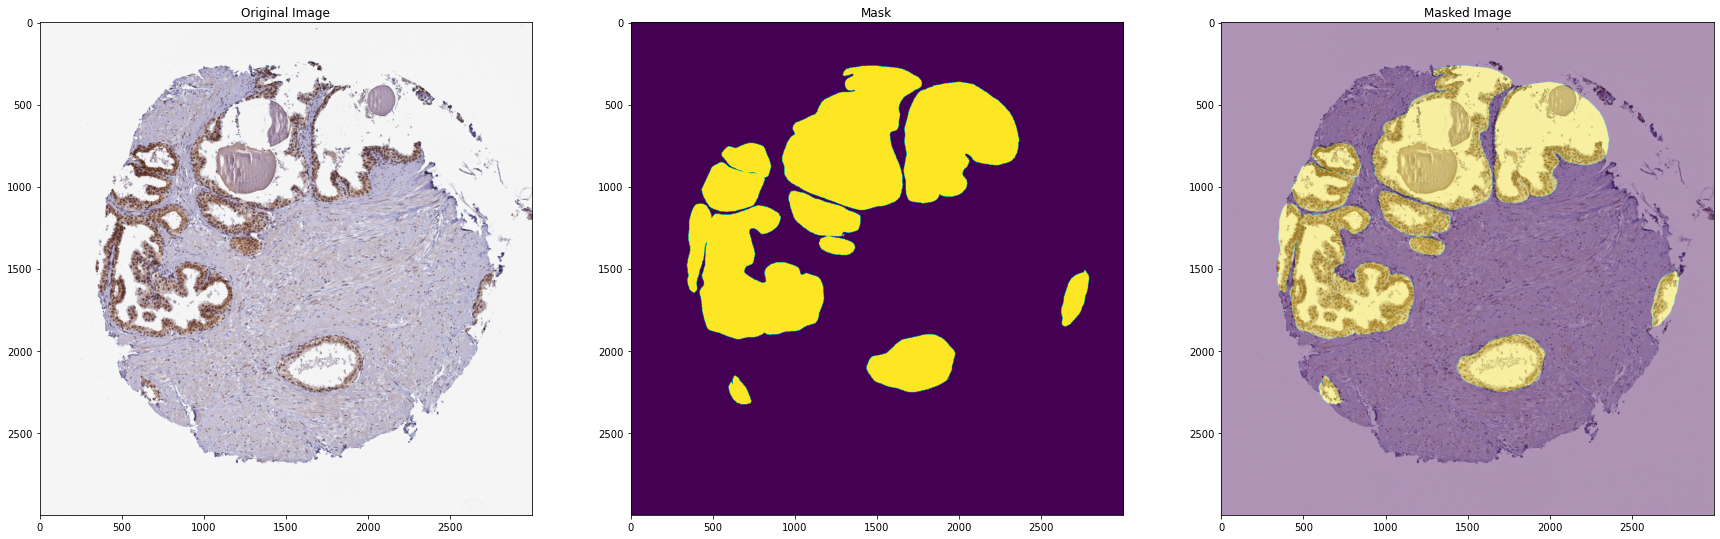

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_tiff)
ax1.set_title('Original Image')
ax2.imshow(sample_img_tiff_mask)
ax2.set_title('Mask')
ax3.imshow(sample_img_tiff)
ax3.imshow(sample_img_tiff_mask, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

In [17]:
sample_img_tiff_mask_oh = np.eye(2)[sample_img_tiff_mask.astype(int)].astype(np.float32)
type(sample_img_tiff_mask_oh), sample_img_tiff_mask_oh.shape, sample_img_tiff_mask_oh.dtype, sample_img_tiff_mask_oh.min(), sample_img_tiff_mask_oh.max()

(numpy.ndarray, (3000, 3000, 2), dtype('float32'), 0.0, 1.0)

La máscara one hot tiene los canales al final, pasar al principio

Es de tipo float32

## Metadatos

In [18]:
plt.style.use("ggplot")

<AxesSubplot:>

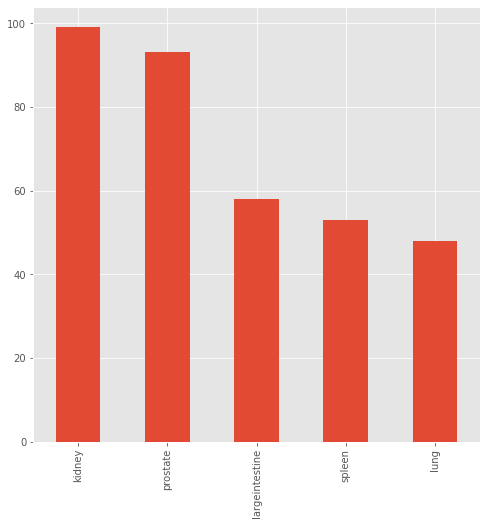

In [19]:
plt.figure(figsize=(8, 8))
train_df.organ.value_counts().plot(kind='bar')

<AxesSubplot:>

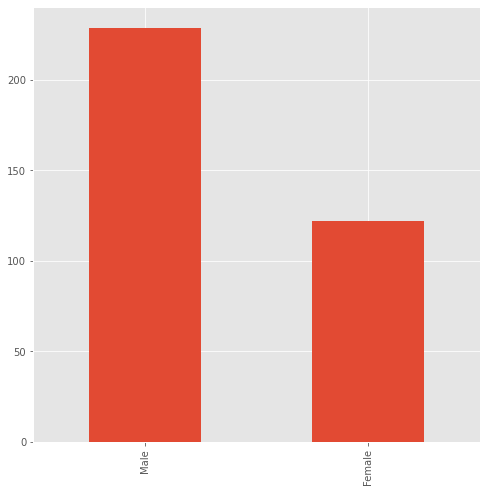

In [20]:
plt.figure(figsize=(8, 8))
train_df.sex.value_counts().plot(kind='bar')

<AxesSubplot:>

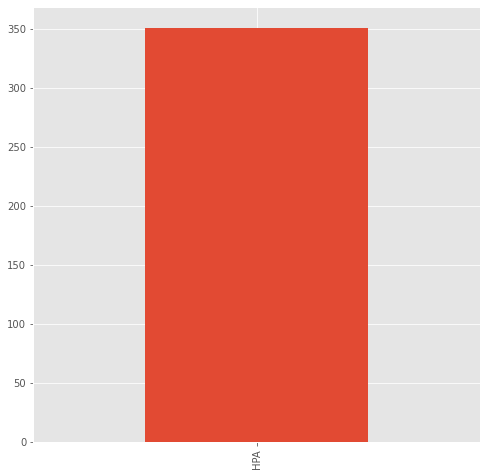

In [21]:
plt.figure(figsize=(8, 8))
train_df.data_source.value_counts().plot(kind='bar')

In [22]:
import seaborn as sns

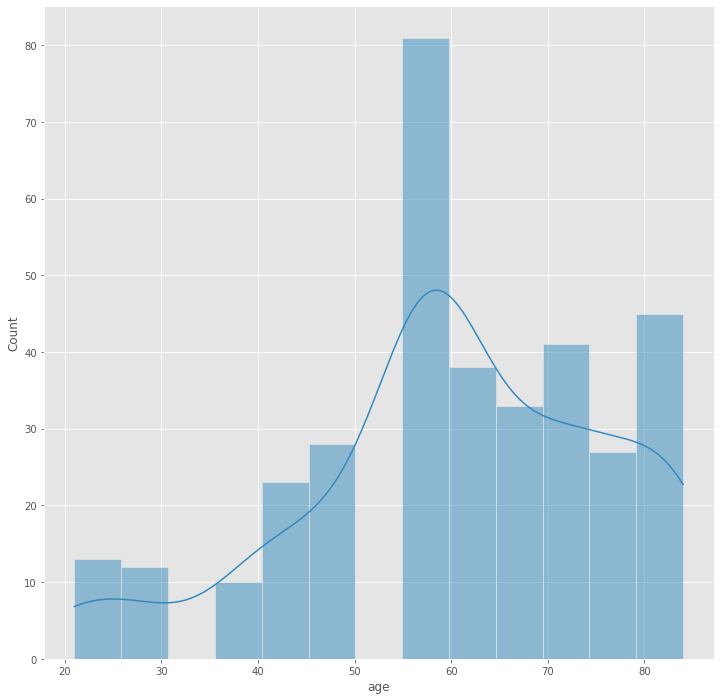

In [23]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", kde=True, data=train_df)
plt.show()

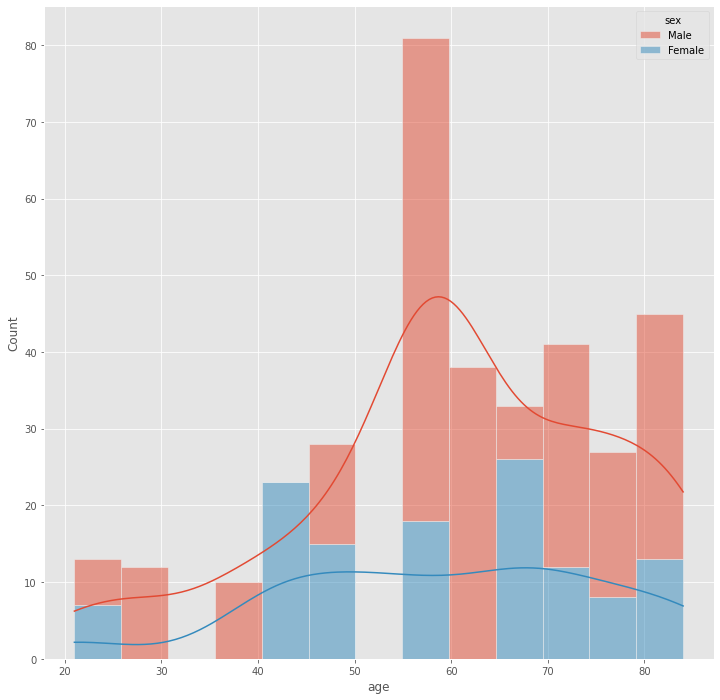

In [24]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", hue="sex", multiple="stack", kde=True, data=train_df)
plt.show()

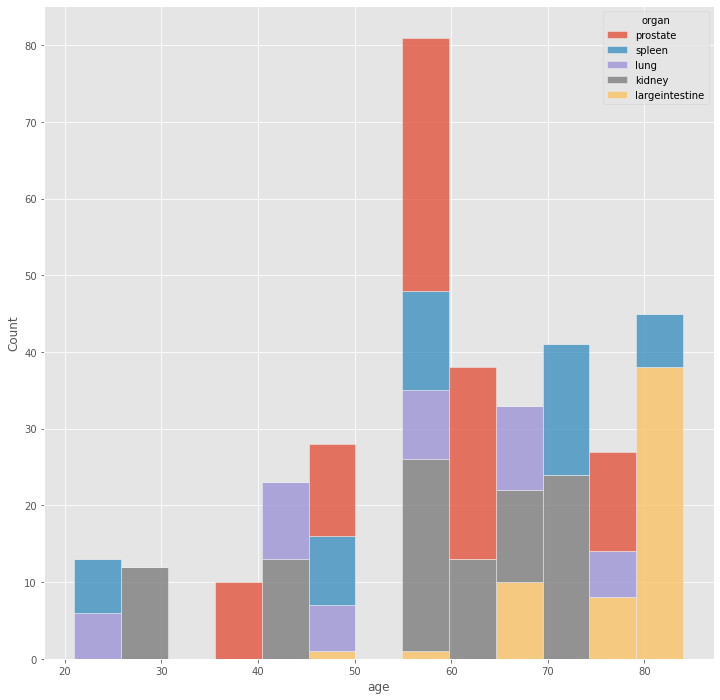

In [25]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", hue="organ", multiple="stack", data=train_df)
plt.show()

<Figure size 864x864 with 0 Axes>

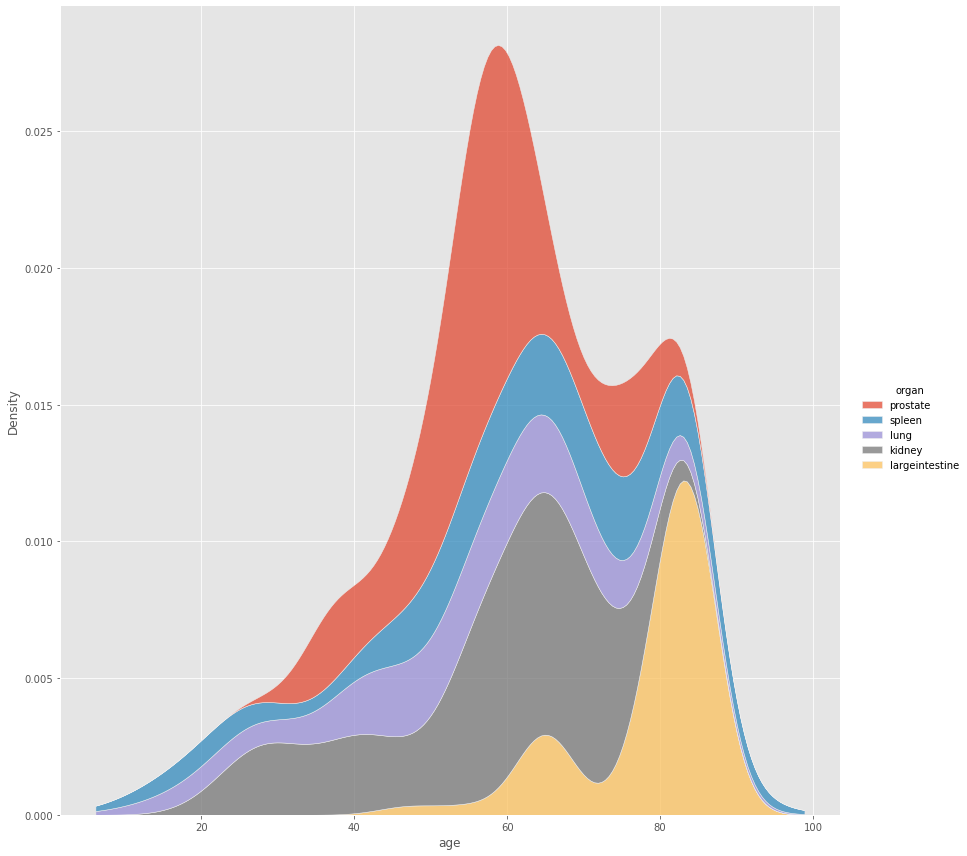

In [26]:
plt.figure(figsize=(12, 12))
sns.displot(x="age", hue="organ", kind="kde", multiple='stack', data=train_df, height=12)

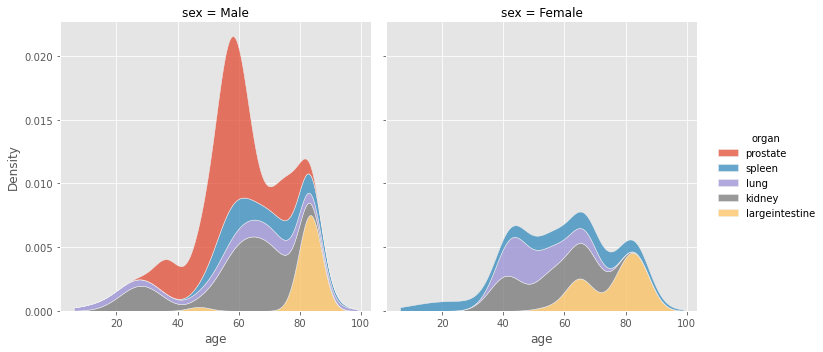

In [27]:
sns.displot(x="age", col="sex", hue="organ", kind="kde", multiple='stack', data=train_df)

<AxesSubplot:xlabel='organ', ylabel='count'>

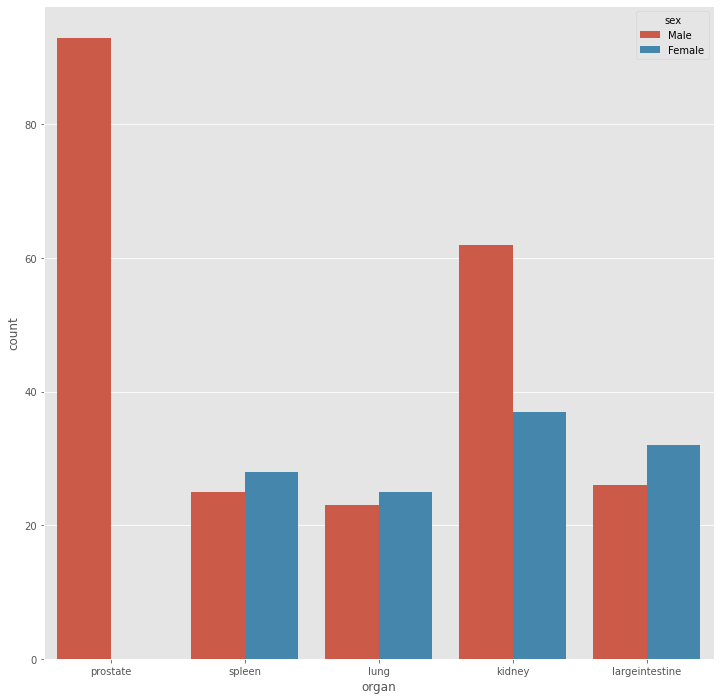

In [28]:
plt.figure(figsize=(12, 12))
sns.countplot(x="organ", hue="sex", data=train_df)

<AxesSubplot:xlabel='organ', ylabel='count'>

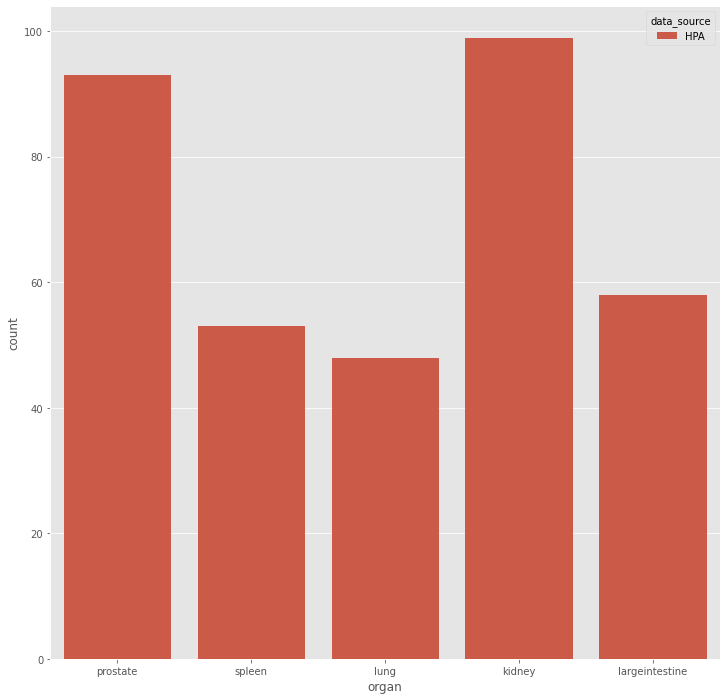

In [29]:
plt.figure(figsize=(12, 12))
sns.countplot(x="organ", hue="data_source", data=train_df)